In [ ]:
# importing libraries
import os, time
os.environ['PYTHONHASHSEED']=str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# %load_ext tensorboard
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
seed = 12

<ipython-input-1-6d6a36f45a00>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


In [ ]:
import tensorflow as tf
from tensorflow import keras as k
print(tf.__version__)
from keras import backend as K
import os, shutil, re, string
import matplotlib.pyplot as plt
import spacy
seed=100

2.12.0


In [ ]:
from skimage.transform import resize
from skimage import img_as_ubyte
from imageio import imread
import datetime

def set_seed():
    global seed
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

# use_tpu = True #@param {type:"boolean"}

# if use_tpu:
#     assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

# if 'COLAB_TPU_ADDR' in os.environ:
#   TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
#   print('Found TPU at: {}'.format(TF_MASTER))
# else:
#   TF_MASTER=''

  
## Checking the GPU configuration
# !nvidia-smi
# tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
import timeit

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

處理data位置，抓取標籤

In [ ]:
import json
folder_main = '/content/drive/MyDrive/Colab Notebooks/food101'
folder_images = os.path.join(folder_main, 'images')
trainjson_fp = folder_main+'/meta/train.json'
testjson_fp = folder_main+'/meta/test.json'
with open(trainjson_fp, 'r') as f:
    trainjson = json.load(f)
with open(testjson_fp, 'r') as f:
    testjson = json.load(f)
labels = list(trainjson.keys())
labels[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
# helper function

def readImg(img):
    global folder_images
    return imread(os.path.join(folder_images, img+'.jpg'))

def showImg(img):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.show()

Total number of samples for train 11250
Some samples are ['baby_back_ribs/2010205', 'cannoli/1078873', 'beef_carpaccio/3252686', 'beignets/1026640', 'bruschetta/624778']
Sample Image Shape (512, 389, 3)


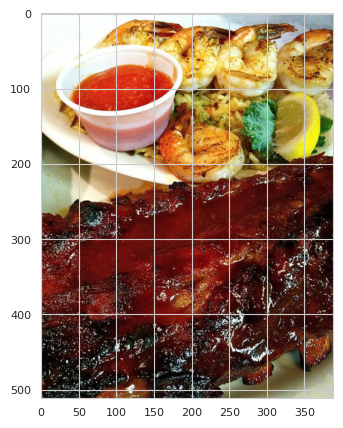

In [ ]:
# create training data
set_seed()
train_samples = list(np.random.permutation(list(pd.core.common.flatten(trainjson.values()))))
print("Total number of samples for train",len(train_samples))
print("Some samples are",train_samples[:5])
sample_img = readImg(train_samples[0])
print("Sample Image Shape",sample_img.shape)
showImg(sample_img)

Total number of samples for test 3750
Some samples are ['cannoli/3851584', 'caprese_salad/2234940', 'carrot_cake/1007814', 'beignets/2966565', 'apple_pie/2559009']
Sample Image Shape (512, 512, 3)


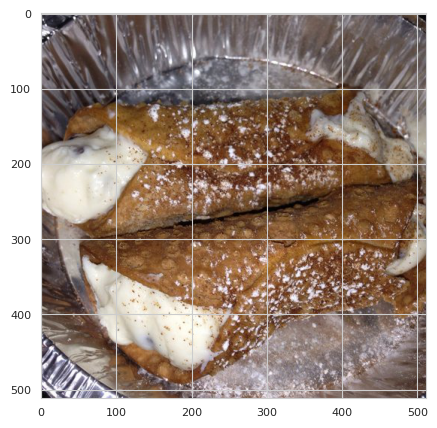

In [ ]:
# create testing data
set_seed()
test_samples = list(np.random.permutation(list(pd.core.common.flatten(testjson.values()))))
print("Total number of samples for test",len(test_samples))
print("Some samples are",test_samples[:5])
sample_img = readImg(test_samples[0])
print("Sample Image Shape",sample_img.shape)
showImg(sample_img)

In [ ]:
# # get image with min size
# shapeX, shapeY = [1000, 1000], [1000, 1000]
# for i, img in enumerate(train_samples):
#     print("\rReading",i+1,"of total",len(train_samples),"images", end='')
#     imgShape = readImg(img).shape
#     if imgShape[0] < shapeX[0]:
#         shapeX = imgShape[:2]
#     if imgShape[1] < shapeY[1]:
#         shapeY = imgShape[:2]
# print("\nLowest training image shape - shapeX:", shapeX,", shapeY:",shapeY)

In [ ]:
train_sample_one = ['lasagna/3787908', 'bread_pudding/1375816', 'steak/1340977']
train_samples = [x for x in train_samples if x not in train_sample_one]
print("Remaining samples for train are",len(train_samples))

Remaining samples for train are 11249


pick data set test

Total number of samples for train 750
Some samples are ['caesar_salad/1146669', 'baklava/1049559', 'bruschetta/1255490', 'apple_pie/1112300', 'bread_pudding/1057665']
Sample Image Shape (512, 512, 3)


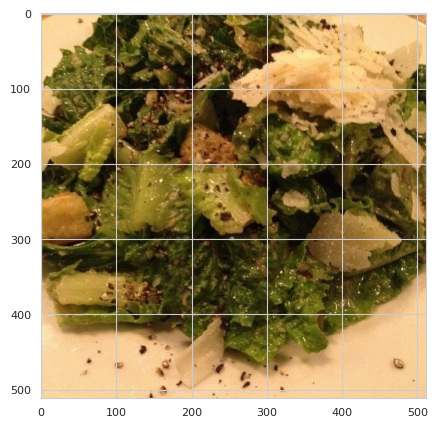

In [ ]:
# create training data
train_samples_subset_list = []
for x in trainjson.keys():
    train_samples_subset_list.extend(trainjson[x][:50])
set_seed()
train_samples_subset = list(np.random.permutation(train_samples_subset_list))
print("Total number of samples for train",len(train_samples_subset))
print("Some samples are",train_samples_subset[:5])
sample_img = readImg(train_samples_subset[0])
print("Sample Image Shape",sample_img.shape)
showImg(sample_img)

In [ ]:
# remove single channel image
train_sample_one = ['lasagna/3787908', 'bread_pudding/1375816', 'steak/1340977']
train_samples_subset = [x for x in train_samples_subset if x not in train_sample_one]
print("Remaining samples for train are",len(train_samples_subset))

Remaining samples for train are 750


Total number of samples for test 300
Some samples are ['caesar_salad/1050382', 'beignets/1125450', 'bruschetta/1287307', 'bruschetta/1018048', 'cannoli/1151563']
Sample Image Shape (384, 512, 3)


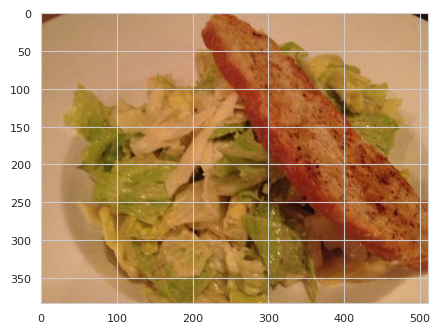

In [ ]:
# create testing data
test_samples_subset_list = []
for x in testjson.keys():
    test_samples_subset_list.extend(testjson[x][:20])
set_seed()
test_samples_subset = list(np.random.permutation(test_samples_subset_list))
print("Total number of samples for test",len(test_samples_subset))
print("Some samples are",test_samples_subset[:5])
sample_img = readImg(test_samples_subset[0])
print("Sample Image Shape",sample_img.shape)
showImg(sample_img)

Setup Labels Encoding

In [ ]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(labels):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14}
{0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: 'beef_carpaccio', 4: 'beef_tartare', 5: 'beet_salad', 6: 'beignets', 7: 'bibimbap', 8: 'bread_pudding', 9: 'breakfast_burrito', 10: 'bruschetta', 11: 'caesar_salad', 12: 'cannoli', 13: 'caprese_salad', 14: 'carrot_cake'}


In [ ]:
# hyper-parameters

img_tensor = [128, 128, 3]

In [ ]:
def cropResize(image, y, z):
    return img_as_ubyte(resize(image, (y,z)))

def normalizeImage(image):
    # applying normalization
    return image/255.0

def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

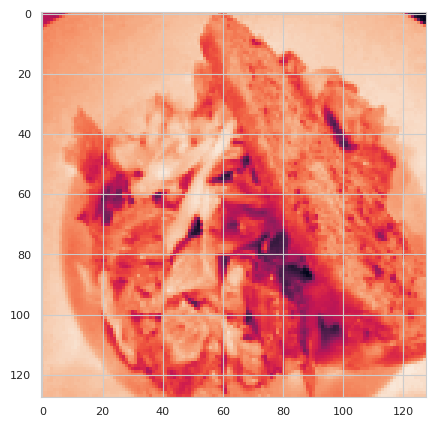

In [ ]:
# display sample preprocessed image 
sample_img_r = sample_img[:, :, 0]
sample_img_r_pre = preprocessImage(sample_img_r, 128, 128)
showImg(sample_img_r_pre)

In [ ]:
# flip
def flipImage(img):
    return np.flip(img)


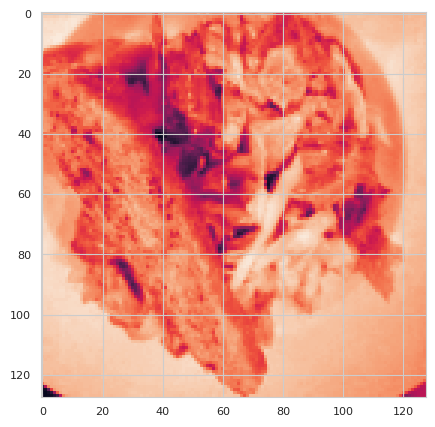

In [ ]:
# display sample preprocessed image 
sample_img_r = sample_img[:, :, 0]
sample_img_r_pre = preprocessImage(flipImage(sample_img_r), 128, 128)
showImg(sample_img_r_pre)

getbitchData & generator function

In [ ]:
def getBatchData(t, batch, batch_size, flip):
    global img_tensor, labels
    [h, w, c] = [img_tensor[0], img_tensor[1], img_tensor[2]]
    batch_data = np.zeros((batch_size,h,w,c)) # generating null image representations
    batch_labels = np.zeros((batch_size, len(labels))) # batch_labels is the one hot representation of output
    if flip:
        batch_data_flip = np.zeros((batch_size,h,w,c))
        batch_labels_flip = np.zeros((batch_size, len(labels)))
    # batch_labels = []
    for idx in range(batch_size): # iterating over the batch_size
        imgPath = t[idx + (batch*batch_size)]
        imgLabel = imgPath.strip().split('/')[0]
        image = readImg(imgPath)

        # separate preprocessImage function is defined for cropping, resizing and normalizing images
        batch_data[idx,:,:,0] = preprocessImage(image[:, :, 0], h, w)
        batch_data[idx,:,:,1] = preprocessImage(image[:, :, 1], h, w)
        batch_data[idx,:,:,2] = preprocessImage(image[:, :, 2], h, w)

        batch_labels[idx, label_index[imgLabel]] = 1

        if flip:
            batch_data_flip[idx,:,:,0] = preprocessImage(flipImage(image[:, :, 0]), h, w)
            batch_data_flip[idx,:,:,1] = preprocessImage(flipImage(image[:, :, 1]), h, w)
            batch_data_flip[idx,:,:,2] = preprocessImage(flipImage(image[:, :, 2]), h, w)

            batch_labels_flip[idx, label_index[imgLabel]] = 1
    if flip:
        batch_data = np.concatenate((batch_data, batch_data_flip))
        batch_labels = np.concatenate((batch_labels, batch_labels_flip))

    return batch_data, batch_labels

In [ ]:
def generator(folder_list, batch_size, flip=False):
    print('\nLoading from', len(folder_list), 'images; batch size =', batch_size)
    while True:
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
#             print("\rReading batch",str(batch+1),"of total",str(num_batches), end='')
            yield getBatchData(folder_list, batch, batch_size, flip)
        
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size_rem = len(folder_list)%batch_size
            yield getBatchData(folder_list, batch, batch_size_rem, flip)

test two function


Loading from 750 images; batch size = 16

Sample Train batch data shape (32, 128, 128, 3)
Train Batch labels [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Sample train batch image


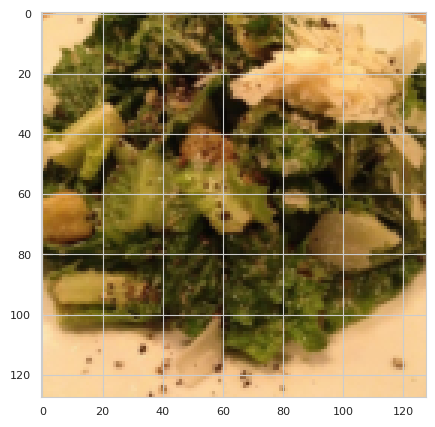


Loading from 300 images; batch size = 8

Sample Test batch data shape (8, 128, 128, 3)
Test Batch labels [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Sample test batch image


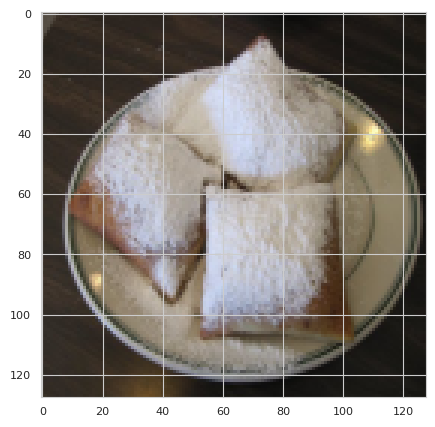

In [ ]:
# check complete batch shape
sample_generator = generator(train_samples_subset, batch_size=16, flip=True)
sample_batch_data, sample_batch_labels = next(sample_generator)
print("\nSample Train batch data shape", sample_batch_data.shape)
print("Train Batch labels", sample_batch_labels[0])
print("Sample train batch image")
showImg(sample_batch_data[0])

# validation batch sample
sample_test_generator = generator(test_samples_subset, batch_size=8)
sample_test_batch_data, sample_test_batch_labels = next(sample_test_generator)
print("\nSample Test batch data shape", sample_test_batch_data.shape)
print("Test Batch labels", sample_test_batch_labels[0])
print("Sample test batch image")
showImg(sample_test_batch_data[-2])

training model function

In [ ]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [ ]:
logPath = './logs/'
if not os.path.exists(logPath):
    os.mkdir(logPath)
# %load_ext tensorboard
# %tensorboard --logdir logPath

# selected set for training and prediction
train_set = train_samples
test_set = test_samples

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        ACCURACY_THRESHOLD = 0.90
        if(logs.get('val_categorical_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True


def trainModel(model, epochs, optimizer, vb=1, modelName='model'):
    global train_set, test_set
    !rm -rf ./logs/
    logs = logPath + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    batch_size = 128
    bestModelPath = './'+modelName+'_model.hdf5'
    callback = myCallback()
    cbs = [callback,
           k.callbacks.TensorBoard(log_dir=logs, histogram_freq=1),
           k.callbacks.ReduceLROnPlateau(monitor = 'val_categorical_accuracy',patience = 5, verbose = 1),
           k.callbacks.EarlyStopping(monitor = 'val_categorical_accuracy',patience = 5,verbose = 1,restore_best_weights = True),
           k.callbacks.ModelCheckpoint(filepath=bestModelPath, monitor='val_loss', verbose=1, save_best_only=True)]

    # setup generators for training
    
    train_generator = generator(train_set, batch_size, flip=True)
    test_generator = generator(test_set, batch_size, flip=True)
    
    num_train_sequences = len(train_set)
    print('# training sequences =', num_train_sequences)
    num_test_sequences = len(test_set)
    print('# test sequences =', num_test_sequences)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_test_sequences%batch_size) == 0:
        validation_steps = int(num_test_sequences/batch_size)
    else:
        validation_steps = (num_test_sequences//batch_size) + 1

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=[k.metrics.CategoricalAccuracy(), k.metrics.Precision(), k.metrics.Recall()]
    )
    return model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,
                               validation_data=test_generator, validation_steps=validation_steps,
                               verbose=vb, batch_size=batch_size, callbacks=cbs)

In [ ]:
# evaluate model with time

def evaluate(model):
    global test_set
    batch_size = 128
    num_train_sequences = len(test_set)
    steps_per_epoch = 0
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    test_generator = generator(test_set, batch_size=batch_size)
    t1 = time.time()
    model = k.models.load_model(model)
    eval_results = model.evaluate_generator(test_generator, steps=steps_per_epoch)
    t2 = time.time()
    print(f'\nAccuracy: {eval_results[1]}, Loss: {eval_results[0]}')
    print(f'Total Prediction Time: {t2-t1}')
    print(f'FPS Prediction Time: {len(test_set)/(t2-t1)}')
    print(f'Prediction Time per Image: {(t2-t1)/len(test_samples_subset)}')

ResNet modle

In [ ]:
resnet = k.applications.ResNet50(weights='imagenet', input_shape=img_tensor, include_top=False)
resnet.trainable = False

model_2 = k.models.Sequential([
    resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    k.layers.Dropout(0.2),
    k.layers.Dense(256, activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Dropout(0.1),
    k.layers.Dense(128, activation='relu'),
    k.layers.BatchNormalization(),
    k.layers.Dropout(0.1),
    k.layers.Dense(len(index_label), activation='softmax')
                             
])
print(model_2.summary())

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                         

In [ ]:
trainModel(model_2, 10, 'adam', modelName='resnet')

# training sequences = 11249
# test sequences = 3750

Loading from 11249 images; batch size = 128
Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 2.8737 - categorical_accuracy: 0.0837 - precision_1: 0.1068 - recall_1: 0.0011 
Loading from 3750 images; batch size = 128

Epoch 1: val_loss improved from inf to 2.70079, saving model to ./resnet_model.hdf5
88/88 [==============================] - 6638s 76s/step - loss: 2.8737 - categorical_accuracy: 0.0837 - precision_1: 0.1068 - recall_1: 0.0011 - val_loss: 2.7008 - val_categorical_accuracy: 0.0919 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 0.0010
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 2.7571 - categorical_accuracy: 0.0968 - precision_1: 0.3000 - recall_1: 5.3338e-04
Epoch 2: val_loss did not improve from 2.70079
88/88 [==============================] - 867s 10s/step - loss: 2.7571 - categorical_accuracy: 0.0968 - precision_1: 0.3000 - recall_1: 5.3338e-04 - val_loss: 2.7

In [ ]:
evaluate('./resnet_model.hdf5')


Loading from 3750 images; batch size = 128

Accuracy: 0.15146666765213013, Loss: 2.5801475048065186
Total Prediction Time: 150.0946409702301
FPS Prediction Time: 24.984236450812247
Prediction Time per Image: 0.500315469900767


In [ ]:
json_string = model_2.to_json()

In [ ]:
model_2.save_weights('food101_weights.h5')